<hr>

# ST1511 AI and Machine Learning CA1 Assignment (Classification)
<hr>

Name: Lee Hong Yi <br>
Class: DAAA/FT/2A/05 <br>
Admin Number: p2223010 <br>

__Objective:__ <br>
Mitigate risk for a bank, by predicting if a customer will default on their payment.

__Background Information:__<br>
A bank has collected data on it's customers, such as their age, gender, level of education, credit limit, and payment history. From this data, the bank would like to predict if a customer would default on their bills, in a attempt to mitigate risk taken.

__Additional Information:__ <br>
A default is a missed or multiple missed payments on money that you have borrowed. An example of a default would be not paying your credit card bill or your monthly mortgage payment. (Investopedia, 2023)
<br>

<hr>
<font size = 5> Importing Libraries </font>
<hr>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.svm import svc
import plotly.express as px
import matplotlib.pyplot as plt
from warnings import simplefilter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ShuffleSplit, GridSearchCV, RandomizedSearchCV, train_test_split

simplefilter(action='ignore', category=FutureWarning)

<hr>
<font size = 5> Preparing data </font>
<hr><br>
Since the data has already been collected, we can move straight onto preparing the data for training by the model.

Dropping columns, as well as creating a copy of the original dataframe to prevent it from being changed during EDA.

In [3]:
original_data = pd.read_csv("./credit_dataset.csv")
eda_data = original_data.copy()
target_data = original_data["Default payment next month"]
analysis_data = original_data.drop(["Customer ID","Default payment next month"], axis  = 1)
analysis_data.head()

,Credit Limit,Gender,Education,Marriage Status,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3
0,20000,female,univeresity,married,24,3913,3102,689,0,689,0
1,120000,female,univeresity,single,26,2682,1725,2682,0,1000,1000
2,90000,female,univeresity,single,34,29239,14027,13559,1518,1500,1000
3,50000,female,univeresity,married,37,46990,48233,49291,2000,2019,1200
4,50000,male,univeresity,married,57,8617,5670,35835,2000,36681,10000


<hr>
<font size = 5>Exploratory Data Analysis</font>
<hr><br>
Before preparing the data to train the model, some exploratory data analysis shall be done first to gain some basic insights into the data.

In [4]:
gender_count = eda_data["Gender"].value_counts()
education_count = eda_data["Education"].value_counts()
marriage_count = eda_data["Marriage Status"].value_counts()

display(gender_count)
display(education_count)
display(marriage_count)

female    940
male      660
Name: Gender, dtype: int64

univeresity      718
post-graduate    604
high school      278
Name: Education, dtype: int64

single     899
married    701
Name: Marriage Status, dtype: int64

Showing the distribution of defaulters based on the credit limit of the customers.

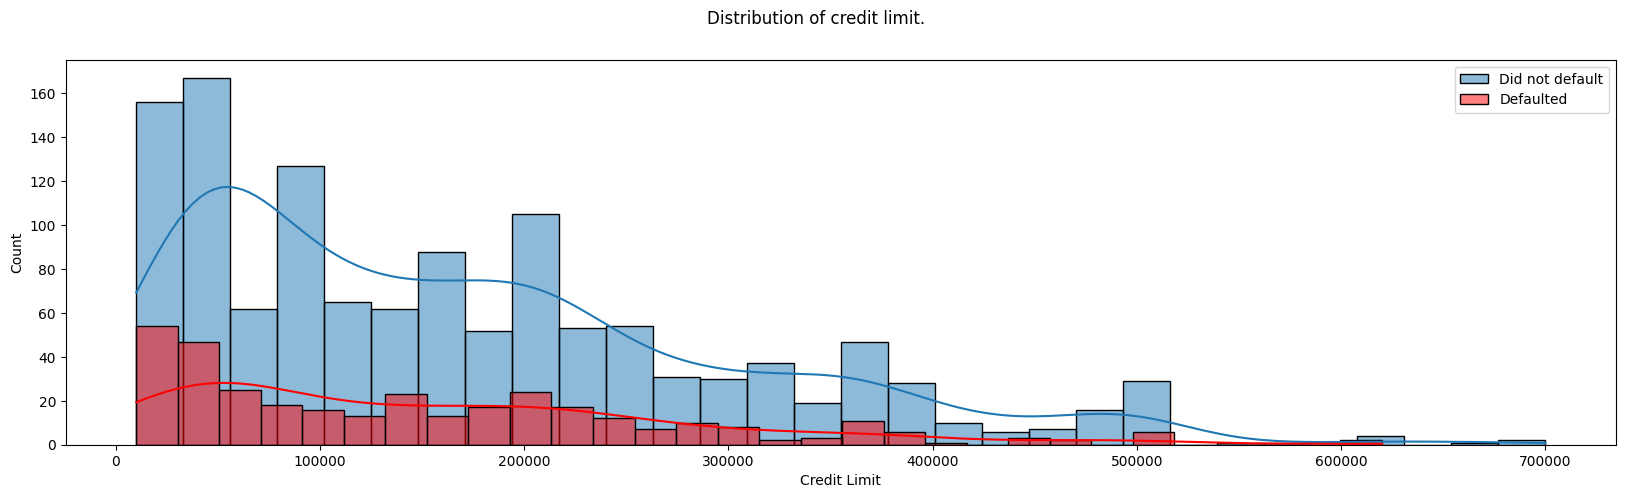

In [5]:
fig, ax = plt.subplots(figsize = (20,5))
fig = sns.histplot(eda_data[eda_data["Default payment next month"] == 0]["Credit Limit"], kde = True, bins = 30, label = "Did not default")
fig2 = sns.histplot(eda_data[eda_data["Default payment next month"] == 1]["Credit Limit"], kde = True, color = "red", bins = 30, label = "Defaulted")
plt.suptitle("Distribution of credit limit.")
ax.legend()
plt.show()

Showing the distribution of defaulters based on the age of the customers.

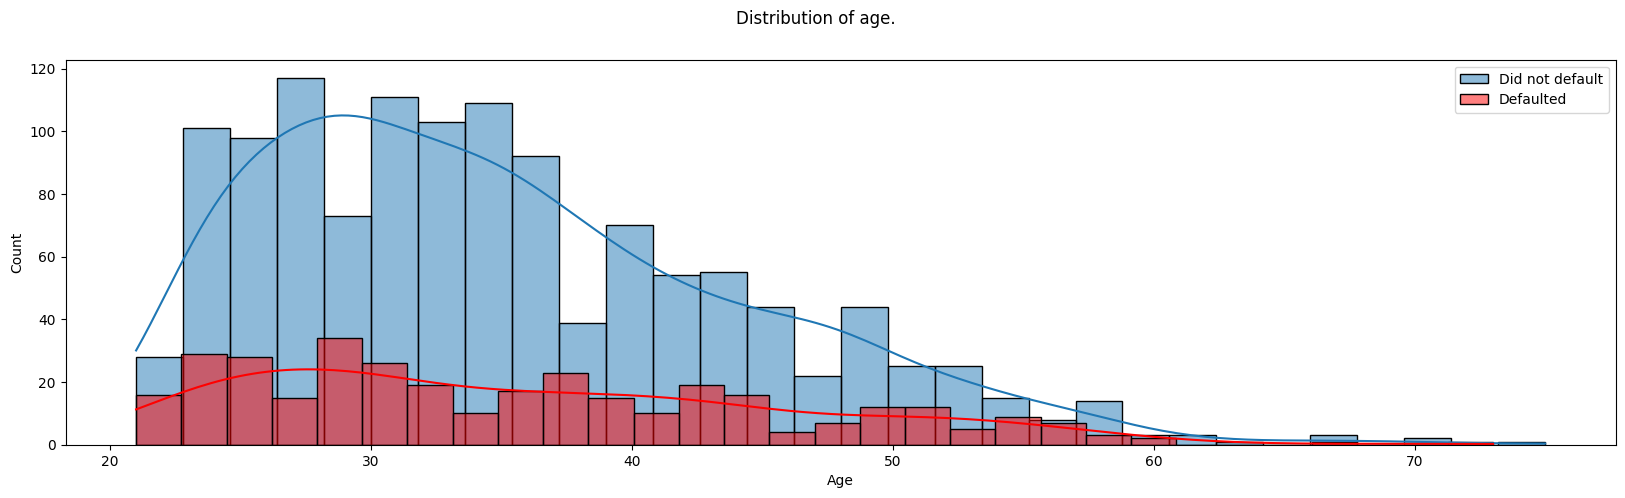

In [6]:
fig, ax = plt.subplots(figsize = (20,5))
fig = sns.histplot(eda_data[eda_data["Default payment next month"] == 0]["Age"], kde = True, bins = 30, label = "Did not default")
fig2 = sns.histplot(eda_data[eda_data["Default payment next month"] == 1]["Age"], kde = True, color = "red", bins = 30, label = "Defaulted")
plt.suptitle("Distribution of age.")
ax.legend()
plt.show()

In [7]:
display(len(eda_data[eda_data["Gender"] == "male"]))
display(len(eda_data[eda_data["Gender"] == "female"]))

660

940

<AxesSubplot: >

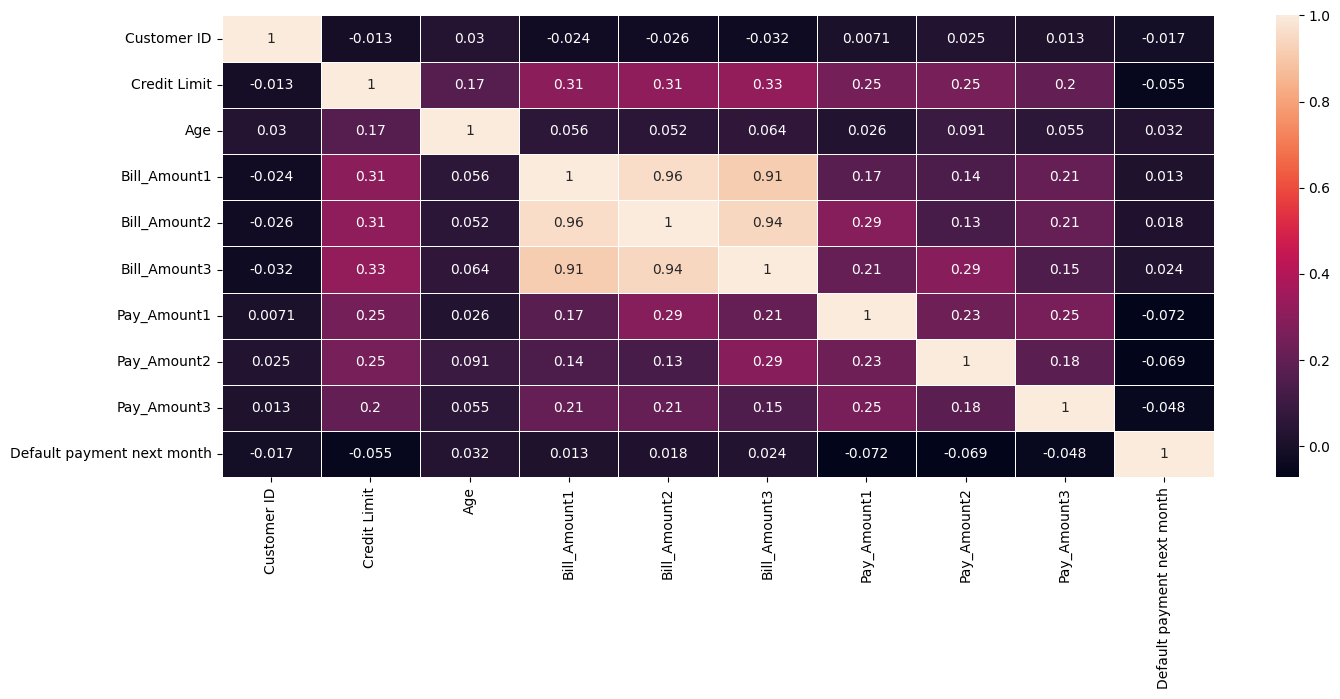

In [8]:
plt.figure(figsize = (16,6))
sns.heatmap(eda_data.corr(), annot = True, linewidths= 0.5)

In [9]:
# data_count = list(gender_count)
# # display(gender_count[0])
# gender_count_dict = dict(male = gender_count[0],female=gender_count[1])
# gender_count_dict = pd.DataFrame(data = gender_count_dict, index = ["Male","Female"])
# ax = sns.barplot(gender_count_dict)
# for i in ax.containers:
    # ax.bar_label(i,)

Performing one-hot encoding to prepare the data to train the models.

In [10]:
analysis_data = pd.get_dummies(analysis_data)
display(analysis_data.head())

,Credit Limit,Age,Bill_Amount1,Bill_Amount2,Bill_Amount3,Pay_Amount1,Pay_Amount2,Pay_Amount3,Gender_female,Gender_male,Education_high school,Education_post-graduate,Education_univeresity,Marriage Status_married,Marriage Status_single
0,20000,24,3913,3102,689,0,689,0,1,0,0,0,1,1,0
1,120000,26,2682,1725,2682,0,1000,1000,1,0,0,0,1,0,1
2,90000,34,29239,14027,13559,1518,1500,1000,1,0,0,0,1,0,1
3,50000,37,46990,48233,49291,2000,2019,1200,1,0,0,0,1,1,0
4,50000,57,8617,5670,35835,2000,36681,10000,0,1,0,0,1,1,0


Splitting the data into training and testing datasets, with a 70/30 split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(analysis_data, target_data, test_size=0.3, random_state=42)

Attempting to train and tune a kNearestNeighbors model with GridSearchCV<br>

Finding the parameters which yield the best accuracy for the training dataset.

In [31]:
param_grid = dict(n_neighbors=list(range(1,35)), weights = ['uniform', 'distance'], algorithm = ['ball_tree', 'kd_tree', 'brute'])
knn = KNeighborsClassifier(n_jobs = -1)
grid = GridSearchCV(knn, param_grid,scoring='accuracy', return_train_score=False, verbose=1)
knn_search=grid.fit(X_train, y_train)
print(knn_search.best_params_)
accuracy = knn_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )

Fitting 5 folds for each of 204 candidates, totalling 1020 fits
{'algorithm': 'ball_tree', 'n_neighbors': 17, 'weights': 'uniform'}
Accuracy for our training dataset with tuning is : 79.6429%


Attempting to train and tune a RandomForest model using GridSearchCV

In [32]:
n_est_arr = list(np.arange(1,10))
for i in list(np.arange(10,100,10)):n_est_arr.append(i)

param_grid = dict(n_estimators= n_est_arr, max_depth= np.arange(1,10,2), max_features =['sqrt', 'log2'])
rfc = RandomForestClassifier(n_jobs = -1)
rfc_grid = GridSearchCV(rfc, param_grid = param_grid, return_train_score=False, verbose=1)
rfc_search = rfc_grid.fit(X_train, y_train)
print(rfc_search.best_params_)
accuracy = rfc_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.4f}%".format(accuracy) )

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 9}
Accuracy for our training dataset with tuning is : 79.9107%


Attempting to train and tune a SVC model using GridSearchCV

<font size = 5 >Evaluating the model</font>

Training a model with the parameters which yieleded the best training accuracy to predict the results of the test data for KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       370
           1       0.00      0.00      0.00       110

    accuracy                           0.75       480
   macro avg       0.38      0.49      0.43       480
weighted avg       0.59      0.75      0.66       480

Accuracy for our testing dataset with tuning is : 75.4167%


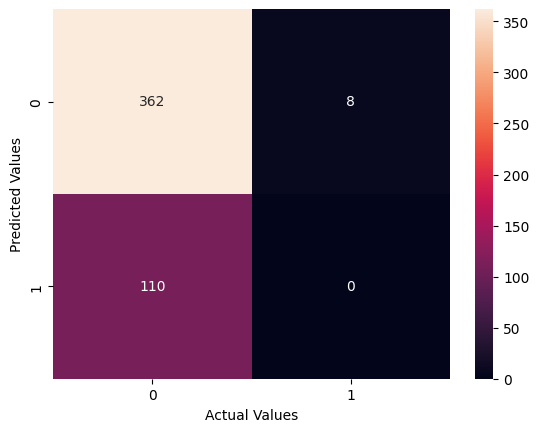

In [30]:
knn = KNeighborsClassifier(algorithm=knn_search.best_params_["algorithm"], n_neighbors = knn_search.best_params_["n_neighbors"], weights = knn_search.best_params_["weights"])
knn.fit(X_train, y_train)
y_test_hat = knn.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
ax = sns.heatmap(confusion_matrix(y_test,y_test_hat), annot= True, fmt = "g")
print(metrics.classification_report(y_test, y_test_hat))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")
print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

Training a model with the parameters which yieleded the best training accuracy to predict the results of the test data for RandomForestClassifier

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       370
           1       0.33      0.01      0.02       110

    accuracy                           0.77       480
   macro avg       0.55      0.50      0.44       480
weighted avg       0.67      0.77      0.67       480

Accuracy for our testing dataset with tuning is : 76.8750%


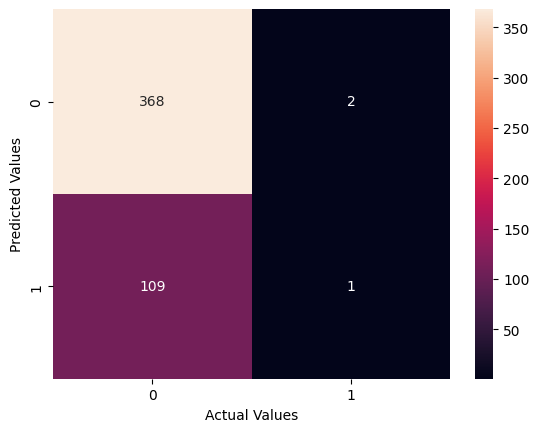

In [33]:
rfc = RandomForestClassifier(max_depth = rfc_search.best_params_["max_depth"], max_features= rfc_search.best_params_["max_features"], n_estimators=rfc_search.best_params_["n_estimators"])
rfc.fit(X_train, y_train)
y_test_hat = rfc.predict(X_test)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
ax = sns.heatmap(confusion_matrix(y_test,y_test_hat), annot= True, fmt = "g")
print(metrics.classification_report(y_test, y_test_hat, zero_division = 0))
ax.set(ylabel = "Predicted Values", xlabel = "Actual Values")

print("Accuracy for our testing dataset with tuning is : {:.4f}%".format(test_accuracy) )

__References__: <br>
1) Investopedia. (2023). Default: What It Means, What Happens When You Default, Examples. [online] Available at: https://www.investopedia.com/terms/d/default2.asp#:~:text=A%20default%20is%20a%20missed,or%20your%20monthly%20mortgage%20payment. [Accessed 5 May 2023].
<br>
2)